In [20]:
import cv2
import imutils
import numpy as np
import cupy as cp
import random
from os import listdir
from os.path import isfile, join
import io
from IPython.display import display
from PIL import Image
import time

#random.seed(19)
z_step_counter = 0

%run ./variables.ipynb
%run ./utils.ipynb

In [21]:
def list_images(DATASET_PATH, diatoms=True):
    # List all images in dataset and putting them in a dict {"key": "imgpath"}
    images_path = []
    for path in DATASET_PATH: images_path.extend([(path, f) for f in listdir(path) if isfile(join(path, f))])
    images_dict = {}
    selected_taxons = get_selected_taxons()
    for image_path in images_path:
        if len(image_path[1].split('.'))>=2 and image_path[1].split('.')[-1]=='png': 
            # defining key
            if diatoms: 
                key = image_path[1].split('_')[1] #key is taxon
                if not key in selected_taxons:
                    key = None
            else: 
                key="mono"
            if not key is None:
                images_dict.setdefault(key,[]).append(image_path)
    return images_dict    

def pick_images(images_dict, min_img=9, max_img=12):
    # Pick random images and add them to list
    n = random.randint(min_img, max_img)
    rand_images = []
    for i in range(n):
        # choosing random images
        rand_key = np.random.choice(list(images_dict.keys()))
        rand_indice = np.random.randint(len(images_dict[rand_key]))
        rand_image_path = images_dict[rand_key][rand_indice]
        # loading image
        image_path = join(rand_image_path[0], rand_image_path[1])
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX)
        rand_images.append({"data":img, "taxon":rand_key})
    
    return rand_images

In [3]:
def patchwork(tmp_images, simple_angles = True, size_px = 1000, overlapping=False, starter=None, scale_factor=1):
    art_img = (np.ones((size_px, size_px))).astype(np.uint8)
    if starter is None:
        global_patch = np.zeros_like(art_img)
        global_patch_mask_rogn = np.zeros_like(art_img)
    else:
        global_patch = starter[0]
        global_patch_mask_rogn = starter[1]
    #global_patch_mask = np.zeros_like(art_img)
    annotations = []
    global z_step_counter
    for img_obj in tmp_images:
        img = resize_img(img_obj["data"], scale_factor)
        w, h = img.shape
        mask = np.ones_like(img)*255
        mask_rogn = round_rectangle(30, w, h, value=255)
        # ROTATING
        if simple_angles:
            angle = random.choice((0,90))
        else:
            angle = random.randint(0,360)

        rotated = imutils.rotate_bound(img, angle)
        rotated_mask = imutils.rotate_bound(mask, angle)
        rotated_mask_rogn = imutils.rotate_bound(mask_rogn, angle)
        #PLACING THE IMAGE WITHOUT OVERLAPPING
        overlap_test = 1
        n_stop = 200
        while overlap_test != 0 and n_stop != 0:
            # TRANSLATING
            px, py = int(rotated.shape[0]/2), int(rotated.shape[1]/2)
            x, y = random.randint(0,size_px-1), random.randint(0,size_px-1) 
            xmin, xmax, ymin, ymax = x-px, x+px, y-py, y+py
            dxmin, dxmax = (0, -xmin)[xmin<0], (0, size_px-1-xmax)[xmax>size_px-1]
            dymin, dymax = (0, -ymin)[ymin<0], (0, size_px-1-ymax)[ymax>size_px-1]
            # PLACING ON TEMPORARY PATCH/MASL
            patch = np.zeros_like(art_img)
            patch_mask = np.zeros_like(art_img)
            patch_mask_rogn = np.zeros_like(art_img)
            patch[xmin+dxmin:xmax+dxmax, ymin+dymin:ymax+dymax] = rotated[dxmin:2*px+dxmax, dymin:2*py+dymax]
            patch_mask[xmin+dxmin:xmax+dxmax, ymin+dymin:ymax+dymax] = rotated_mask[dxmin:2*px+dxmax, dymin:2*py+dymax]
            patch_mask_rogn[xmin+dxmin:xmax+dxmax, ymin+dymin:ymax+dymax] = rotated_mask_rogn[dxmin:2*px+dxmax, dymin:2*py+dymax]
            # Testing if there is overlapping by comparing to global mask
            if overlapping:
                break
            overlap_test = len(np.nonzero(np.logical_and(patch_mask, global_patch_mask_rogn))[0])
            n_stop -= 1
        if n_stop > 0:
            # (erosion to get rid of black edges)
            kernel_size = 3
            kernel = np.ones((kernel_size,kernel_size),np.uint8)
            patch_mask = cv2.erode(patch_mask,kernel,iterations = 1)
            patch_mask_rogn = cv2.erode(patch_mask_rogn,kernel,iterations = 1)
            # filling global patches
            cv2.copyTo(patch, patch_mask_rogn, global_patch)
            #cv2.copyTo(patch_mask, patch_mask, global_patch_mask)
            cv2.copyTo(patch_mask_rogn, patch_mask_rogn, global_patch_mask_rogn)
            patch_mask_rogn[patch_mask_rogn>0]=1
            annotations.append({
                "taxon": img_obj["taxon"],
                "xmin": xmin+dxmin,
                "ymin": ymin+dymin,
                "xmax": xmax+dxmax,
                "ymax": ymax+dymax,
                "patch_mask": patch_mask_rogn,
                "z_index": z_step_counter
                
            })
            z_step_counter+=1
    #CREATING FINAL IMAGE
    cv2.copyTo(global_patch, global_patch_mask_rogn, art_img)
    return global_patch, global_patch_mask_rogn, annotations

In [52]:
def img_filling(global_patch, global_patch_mask_rogn, sigma=10e3, verbose=False):
    final_img = global_patch.copy()
    acc, accw = np.zeros_like(final_img).astype(np.float32), np.zeros_like(final_img).astype(np.float32)
    conts, h = cv2.findContours(global_patch_mask_rogn, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # Getting indices
    height=final_img.shape[0]
    width=final_img.shape[1]
    indices = np.indices((height*2,width*2))
    xMap = indices[0]
    yMap = indices[1]
    d2 = np.square(xMap - width) + np.square(yMap - height)
    W = np.exp(-d2/sigma)
    W[W<1e-10] = 1e-10
    # Looping
    i = 0
    known = np.concatenate(conts)
    for kp in known:
        # Counter
        if verbose and i%2000==0:
            print(i, "/", len(known))
        i += 1
        # Init
        xkp, ykp = kp[0][1], kp[0][0]
        val = final_img[xkp, ykp]
        # FILLING
        w = W[height-ykp:2*height-ykp,width-xkp:2*width-xkp]
        acc += w*val
        accw += w
    acc = np.divide(acc, accw)
    acc_img = acc.astype(np.uint8)
    final_img[global_patch_mask_rogn==0]=acc_img[global_patch_mask_rogn==0]
    return final_img

In [63]:
def fast_img_filling(global_patch, global_patch_mask_rogn, sigma=10e3, verbose=False):
    # IMPROVED img_filling USING CUPY
    final_img = cp.asarray(global_patch)
    acc, accw = cp.zeros_like(final_img).astype(np.float32), cp.zeros_like(final_img).astype(np.float32)
    # Finding contours
    conts, h = cv2.findContours(global_patch_mask_rogn, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # Getting indices
    height=global_patch.shape[0]
    width=global_patch.shape[1]
    indices = np.indices((height*2,width*2))
    xMap = cp.asarray(indices[0])
    yMap = cp.asarray(indices[1])
    d2 = cp.square(xMap - width) + cp.square(yMap - height)
    W = cp.exp(-d2/sigma)
    W[W<1e-10] = 1e-10
    # Looping
    i = 0
    known = np.concatenate(conts)
    for kp in known:
        # Counter
        if verbose and i%2000==0:
            print(i, "/", len(known))
        i += 1
        # Init
        xkp, ykp = kp[0][1], kp[0][0]
        val = final_img[xkp, ykp]
        # FILLING
        w = W[height-ykp:2*height-ykp,width-xkp:2*width-xkp]
        acc += w*val
        accw += w
    acc = cp.divide(acc, accw)
    acc_img = acc.astype(np.uint8)
    
    # sticking the diatoms
    tmp_global_patch_mask_null = cp.asarray(global_patch_mask_rogn)==0
    final_img[tmp_global_patch_mask_null]=acc_img[tmp_global_patch_mask_null]
    final_img = cp.asnumpy(final_img)
    return final_img

In [64]:
def blur_contours(final_image, annotations):
    # 01 - Creating border image
    pixels_to_blur = []
    contour_image = np.zeros_like(final_image)
    for annotation in annotations:
        mask = annotation["patch_mask"]
        z_index = annotation["z_index"]
        # Keeping overlapping pixels iff the image is on top
        for tmp_annotation in annotations:
            tmp_mask = tmp_annotation["patch_mask"]
            tmp_z_index = tmp_annotation["z_index"]
            if tmp_z_index>z_index:
                tmp_and = np.logical_and(mask, tmp_mask)
                if len(np.where(tmp_and!=0)[0]):
                    mask[tmp_mask!=0]=0
        conts, h = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for cont in conts:
            for kp in cont:
                xkp, ykp = kp[0][1], kp[0][0]
                max_xkp, max_ykp = final_image.shape
                if xkp>1 and ykp>1 and xkp<max_xkp-3 and ykp<max_ykp-3:
                    contour_image[xkp, ykp] = 1
    contour_image = cv2.dilate(contour_image, cv2.getStructuringElement(cv2.MORPH_RECT,(7,7)),iterations = 1)
    # 02 - Blurring borders
    kernel_size = 5
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))/(kernel_size*kernel_size)
    final_image_blurred = cv2.filter2D(final_image,-1,kernel)
    final_image[contour_image!=0]=final_image_blurred[contour_image!=0]
    return final_image

In [65]:
def main_generator(simple_angles = False, size_px = 1000, fast=False, verbose=False, overlapping=False):
    # Listing images randomly in datasets
    # if images has already been listed, do not list them again to save some performances
    if not hasattr(main_generator, 'images_dict'):
        main_generator.images_dict = list_images(DATASET_PATH, diatoms=True)
        main_generator.images_dict_dust = list_images(DATASET_DUST_PATH, diatoms=False)
    # Picking randomly in images
    rand_images = pick_images(main_generator.images_dict, 9, 12)
    rand_images_dust = pick_images(main_generator.images_dict_dust, 15, 20)
    # Placing them randomly on the artboard
    global z_step_counter
    z_step_counter = 0
    global_patch, global_patch_mask_rogn, annotations = patchwork(rand_images, 
                                                                  simple_angles=simple_angles, 
                                                                  size_px=size_px, 
                                                                  overlapping=overlapping) 
    global_patch, global_patch_mask_rogn, annotations_dust = patchwork(rand_images_dust, 
                                                  simple_angles=simple_angles, 
                                                  size_px=size_px, 
                                                  overlapping=False, 
                                                  starter=[global_patch, global_patch_mask_rogn],
                                                  scale_factor=0.3) 
    # Filling the gaps
    if fast:
        final_image = fast_img_filling(global_patch, global_patch_mask_rogn, sigma=10e3, verbose=verbose)
    else:
        final_image = img_filling(global_patch, global_patch_mask_rogn, sigma=10e3, verbose=verbose)
    # Blurring the edges
    final_image = blur_contours(final_image, annotations+annotations_dust)
    
    if verbose:
        print("Finished!")
        display(Image.fromarray(np.hstack([global_patch, global_patch_mask_rogn])))
        img_bb = final_image.copy()
        color = (255, 0, 0)
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 1
        for annotation in annotations:
            img_bb = cv2.rectangle(img_bb, (annotation["ymin"], annotation["xmin"]), (annotation["ymax"], annotation["xmax"]), color, 4)
            img_bb = cv2.putText(img_bb,  annotation["taxon"], (annotation["ymin"], annotation["xmin"]), font, fontScale, color, 6, cv2.LINE_AA) 
        display(Image.fromarray(img_bb))
    return final_image, annotations

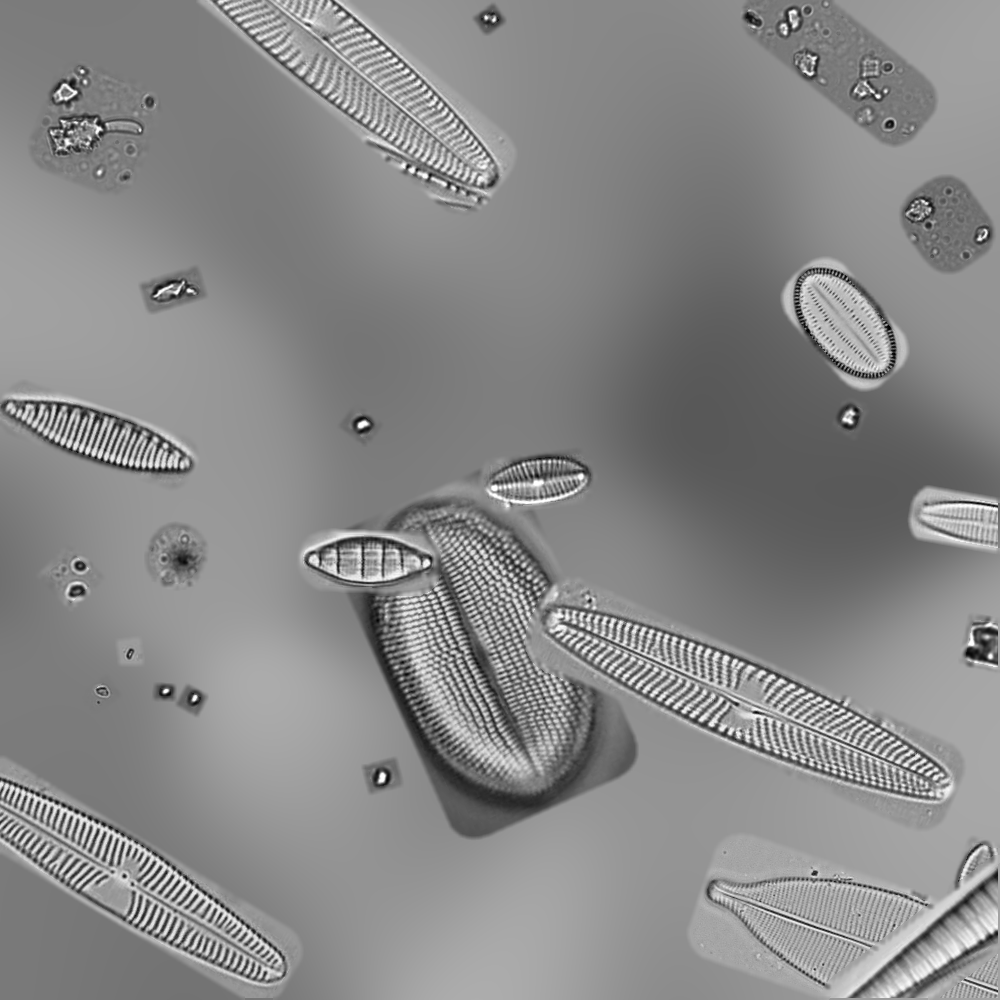

1.828406572341919


In [68]:
#start=time.time()
#random.seed(25)
#final_image, annotations = main_generator(simple_angles = False, size_px = 1000, fast=True, verbose=False, overlapping=True)
#display(Image.fromarray(final_image))
#print(time.time()-start)